# Hierarchical Attention Neural Network
---

This notebook demonstrates how to train and evaluate the neural network I presented to you. This notebook has the code for preparing the data, setting up the model objects, and training. If you are looking for the code for these models they are contained in two files in the directory:

    hierarchical.py
    training.py
    
I've commented the code in there so hopefully it is clear.

I also talk about the penalty I added to the loss function that rewards entropy of predicted probabilities. You can find the explanation after the data preparation section.

Enjoy!
Kiefer

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from hierarchical import *
from training import *

## Prepare Data
---



In [2]:
words = pd.read_csv('./parsed_labels.csv')
# drop some columns that are holdovers from a previous save and not needed:
words.drop(['inds','labels'], axis=1, inplace=True)

words['parsed'] = words['parsed'].map(lambda x: x.strip())
print(words.shape)
words.head()

(2930, 6)


,num_seen,message,empathy,parsed,num_words,polarity
0,1,loving my family sad for his relationship,affectionate,loving my family sad for his relationship,7,1.0
1,1,angry disappointed hopeless,angry,angry disappointed hopeless,3,-1.0
2,1,like i want to scream and beat the shit out of...,angry,like i want to scream and beat the shit out of...,12,-1.0
3,1,im sad and angry,angry,im sad and angry,4,-1.0
4,1,i am very angry and very sad,angry,i am very angry and very sad,7,-1.0


After parsing there are some messages that are considered duplicates. Below you can see a subset of the data where parsed is not unique:

In [3]:
words[words.parsed.duplicated()].tail()

,num_seen,message,empathy,parsed,num_words,polarity
2681,4,i am sad,sad,i am sad,3,-1.0
2723,27,not good,sad,not good,2,-1.0
2725,36,terrible,sad,terrible,1,-1.0
2729,125,not good,sad,not good,2,-1.0
2731,644,sad,sad,sad,1,-1.0


We should retain the `num_seen` counts of the duplicates (which is actually something I didn't do for the presentation analysis) and then drop the duplicated rows.

In [4]:
# get the total num_seen by parsed:
num_seen_to_add = words[words.parsed.duplicated()].groupby('parsed')['num_seen'].agg(np.sum).reset_index()
num_seen_to_add

,parsed,num_seen
0,,1
1,amazing,3
2,feel good,17
3,feeling good,69
4,good,28
5,good but not great,1
6,good having fun,2
7,good i think,3
8,great,11
9,happy,28


In [5]:
# drop the duplicate rows from the dataset
words = words[~words.parsed.duplicated()]
print(words.shape)

(2855, 6)


In [6]:
# merge the to-add counts to the data:
num_seen_to_add.columns = ['parsed','num_seen_add']
words = words.merge(num_seen_to_add, on='parsed', how='left')

# fill in null adds with 0:
words.loc[words.num_seen_add.isnull(), 'num_seen_add'] = 0

# combine num_seen with additions and then remove the num_seen_add columnn
words.num_seen = words.num_seen + words.num_seen_add
words.drop('num_seen_add', axis=1, inplace=True)

In [7]:
words.head()

,num_seen,message,empathy,parsed,num_words,polarity
0,1.0,loving my family sad for his relationship,affectionate,loving my family sad for his relationship,7,1.0
1,1.0,angry disappointed hopeless,angry,angry disappointed hopeless,3,-1.0
2,1.0,like i want to scream and beat the shit out of...,angry,like i want to scream and beat the shit out of...,12,-1.0
3,1.0,im sad and angry,angry,im sad and angry,4,-1.0
4,1.0,i am very angry and very sad,angry,i am very angry and very sad,7,-1.0


Some empathies just don't appear very frequently. I will set a threshold of 5 for what I consider unacceptably infrequent empathies.

In [8]:
empathy_counts = words.empathy.value_counts()
infrequent = empathy_counts[empathy_counts < 5]
infrequent

scared          4
motivated       4
relief          4
bored           4
confused        3
playful         3
sexy            3
creative        2
stable          2
panic           2
embarrassed     2
ignored         1
restless        1
affectionate    1
lazy            1
uneasy          1
frustrated      1
loved           1
intoxicated     1
annoyed         1
flustered       1
Name: empathy, dtype: int64

Make sure that these empathies don't have huge `num_seen` counts:

In [9]:
# as you can see, they have low (1 or 2) counts, and so we can safely remove them.
words.loc[words.empathy.isin(infrequent.index.values), ['empathy','num_seen','parsed']]

,empathy,num_seen,parsed
0,affectionate,1.0,loving my family sad for his relationship
7,annoyed,1.0,good but irritated
107,bored,1.0,bored and slightly depressed
108,bored,1.0,bored as shit
109,bored,1.0,bored tired disappointed
110,bored,1.0,bored and hopeless
124,confused,1.0,im feeling a bit confused kind of down mostly ...
125,confused,1.0,sad and fuzzy and confused
126,confused,1.0,confuse but good
127,creative,1.0,ok i guess been drawing happy with the result ...


Remove the infrequent empathies from the dataset.

In [10]:
words = words[~words.empathy.isin(infrequent.index.values)]
words.reset_index(drop=True, inplace=True)
print(words.shape)

(2812, 6)


Now we need to code the empathies as integer labels to be input to the neural network:

In [11]:
empathy_le = LabelEncoder()
empathy_le.fit(words.empathy.unique())
words['label'] = empathy_le.transform(words.empathy)

Encode the parsed messages as list of list character indices. We can remove the space character since this network takes whole words at once. 

End-of-word and end-of-sentence indices are added by the `char_to_inds` function.

> Note: I have changed the format/behavior of the indices slightly from when I presented. Before there was a start-of-sentence and end-of-sentence placeholder. I think the start-of-sentence doesn't have a lot of value and also thought that end-of-word was missing from the original setup!

In [12]:
# get unique chars and remove the space (will be lowercase alphabet):
all_chars = [x for x in np.unique(list(' '.join(list(words.parsed.values)))) if not x == ' ']
chars_size = len(all_chars)+3

# fit the character to index label encoder:
char_le = LabelEncoder()
char_le.fit(all_chars)

# set up placeholder indices: one for unknown, one for end of word, one for end of sentence:
ZERO_IND = 0
EOW_IND = 1
EOS_IND = 2

# convert the parsed messages into index lists:
words['char_inds'] = words.parsed.map(lambda x: char_to_inds(x, char_le, eow_ind=EOW_IND, eos_ind=EOS_IND))
words['num_chars'] = words.char_inds.map(lambda x: len(x))

words.head()

,num_seen,message,empathy,parsed,num_words,polarity,label,char_inds,num_chars
0,1.0,angry disappointed hopeless,angry,angry disappointed hopeless,3,-1.0,0,"[[3, 16, 9, 20, 27, 1], [6, 11, 21, 3, 18, 18,...",4
1,1.0,like i want to scream and beat the shit out of...,angry,like i want to scream and beat the shit out of...,12,-1.0,0,"[[14, 11, 13, 7, 1], [11, 1], [25, 3, 16, 22, ...",13
2,1.0,im sad and angry,angry,im sad and angry,4,-1.0,0,"[[11, 15, 1], [21, 3, 6, 1], [3, 16, 6, 1], [3...",5
3,1.0,i am very angry and very sad,angry,i am very angry and very sad,7,-1.0,0,"[[11, 1], [3, 15, 1], [24, 7, 20, 27, 1], [3, ...",8
4,1.0,jealous and mad,angry,jealous and mad,3,-1.0,0,"[[12, 7, 3, 14, 17, 23, 21, 1], [3, 16, 6, 1],...",4


## Create observation weights according to `num_words`
---

Some messages are written in a huge amount of times, and we want the model to do well on those. Rather than upsampling now, I can create a weighting vector for the observations. For now it will be the frequencies by phrase stored in `num_seen`.

In [13]:
obs_weights = words.num_seen.values

Split the upsampled data into training and testing, with 80/20 split. Also split the observation weights along the same indices, then inver the training observation frequencies and convert to probability of selection.

**Using this approach the training and testing set will have completely unique messages!** That may be desirable or undesirable to you, depending on your perspective. It's certainly a more difficult problem for the network to solve. The alternative is to first upsample the dataset according to `num_words` and then split after that. Then the repeated message are likely to appear in both.

In [14]:
from sklearn.model_selection import train_test_split

training, testing, train_obs_weights, _ = train_test_split(words, obs_weights, test_size=0.2, 
                                                           stratify=words.label.values,
                                                           random_state=779)
print(training.shape, train_obs_weights.shape, testing.shape)

train_obs_weights = 1./train_obs_weights
train_obs_weights = train_obs_weights/np.sum(train_obs_weights)

(2249, 9) (2249,) (563, 9)


Subset down the training and testing to just columns we want, and then create a `class_weight` vector based on the occurances of the empathy targets. 

The weighting for a class (which is applied during the calculation of the loss) is it's inverse frequency in the training data.

In [15]:
training = training[['num_seen','empathy','parsed','label','char_inds']]
testing = testing[['num_seen','empathy','parsed','label','char_inds']]

class_weights = 1./training.groupby('label')['num_seen'].agg(np.sum).sort_index()
class_weights = class_weights.values*class_weights.shape[0]


pd.DataFrame({'frequency':training.groupby('label')['num_seen'].agg(np.sum).sort_index().values,
              'class_weight':class_weights},
             index=training['label'].value_counts().sort_index().index)

,class_weight,frequency
0,5.200000,5.0
1,6.500000,4.0
2,0.400000,65.0
3,1.857143,14.0
4,4.333333,6.0
5,6.500000,4.0
6,0.120930,215.0
7,0.590909,44.0
8,0.650000,40.0
9,3.714286,7.0


## Set up the network
---

Below we set up the hierarchical network with the parameters for layer sizes, dropout amounts, and some other options.

    char_emb_size = 16
        This is the dimensionality of the embedding vector for characters. This means
        that a given character, for example 'f', is represented by a vector of 16 numbers.
        This vector representation is trainable by the network.
    num_empathies = 26
        The count of the target empathy classes. This will be the size of the final output
        of the network - the class likelihoods as predicted by the message representation.
    word_hidden_size = 50
        The word vector representation size. Because the RNN is bidirectional this vector
        will internally actually be 100 units.
    message_hidden_size = 50
        The message vector representation. Again, like the words, this will turn out to be
        100 due to the bidirectional RNN. So, your output message representations will be
        100 dimensions per message.
    word_context_size = 50
        This is the size of the trainable "attention" layer in the CharToWord section of the
        network.
    message_context_size = 50
        This is the size of the trainable "attention" layer in the WordToMessage section.
    intermediate_nonlinear_layer = True
        This adds a layer between the message and output prediction layer with a nonlinear
        activation function. Note that you will lose the ability to say that the output 
        likelihoods/probabilities are a linear transformation of the message vectors!
        
I have also set the "dropout" probabilities for word, message, and output to be 0.2. These dropouts are applied at the representation level only. What this means is that there is a 20% chance that outgoing weights from a representation will be "dropped" or missing. Dropout is a good way to regularize neural networks (though can be tricky with RNNs) and is the conceptual equivalent to ensembling of models.

> Note: The model I presented had `intermediate_nonlinear_layer = False` because I wanted the likelihoods of classes to be a linear transformation of the message representations. I've set it to `True` just to demonstrate in the model below. It'd definitely be worth investigating how the message vectors differ between the two models!

In [16]:
char_emb_size = 16
num_empathies = len(words['label'].unique())
word_hidden_size = 50
message_hidden_size = 50
word_context_size = 50
message_context_size = 50
intermediate_nonlinear_layer = True

gru = HierarchicalAttentionRNN(chars_size, char_emb_size, word_hidden_size, message_hidden_size, 
                               word_context_size, message_context_size, num_empathies,
                               word_dropout_p=0.2, message_dropout_p=0.2, output_dropout_p=0.2,
                               char_projection_nonlinearity=nn.ELU, 
                               word_projection_nonlinearity=nn.ELU,
                               intermediate_output_step=intermediate_nonlinear_layer,
                               char_to_word_rnn=nn.GRU, word_to_message_rnn=nn.GRU)

Set up the save files. One is saved upon completion, the other is saved when the network achieves its best performance on the test set.

In [17]:
save_file = './test_params.pt'
save_best = './test_params_best.pt'

Pull out the required numpy arrays from the pandas DataFrames.

In [18]:
train_targets = training['label'].values
train_char_indices = training['char_inds'].values

test_targets = testing['label'].values
test_char_indices = testing['char_inds'].values
test_messages = testing['parsed'].values

A dictionary mapping the labels to the empathies is required by the `Evaluation` class. (This class is used for testing and printing out examples.)

In [19]:
target_ref_dict = words[['label','empathy']].drop_duplicates()
target_ref_dict = {k:v for k,v in zip(target_ref_dict.label.values,
                                      target_ref_dict.empathy.values)}

The `Evaluation` object requires:
    
    test_char_indices
        these are the list-of-list indices from the test set
    test_targets
        these are the empathy labels from the test set
    test_messages
        the actual message text corresponding to the character indices
    target_ref_dict
        a label-to-empathy mapping dictionary
    char_le
        the label encoder for the characters
        
This object performs testing, demoing, and printing examples.

In [20]:
E = Evaluation(test_char_indices, test_targets, test_messages, target_ref_dict, char_le)

## Entropy loss function penalty
---

OK before going forward it is important to cover the entropy penalty I added to the loss function of the neural network. It is not something that was within the scope of my presentation but it has an important regularizing effect on the network's outputs (if you choose to use it!).

Entropy is an old concept from information theory. It is a metric that measures the expected information from a probability distribution of possible events. When outcomes are certain, entropy is zero. As probability of events becomes more uniform, entropy increases.

You can calculate the entropy of a distribution of outcomes as:

### $$ H(X) = - \sum_{i=1}^n P(x_i)\;ln(P(x_i)) $$

As a relevant example, let's take the predicted probabilities empathy class membership for a given message. Below I'll set up two fake probability distributions across empathies. You can see that the entropy for the distribution where an outcome is much more likely relative to the others has a lower empathy than the more uniform distribution.

In [21]:
import scipy.stats as stats

def entropy(p_vector):
    return -1 * np.sum(p_vector * np.log(p_vector + 1e-12))

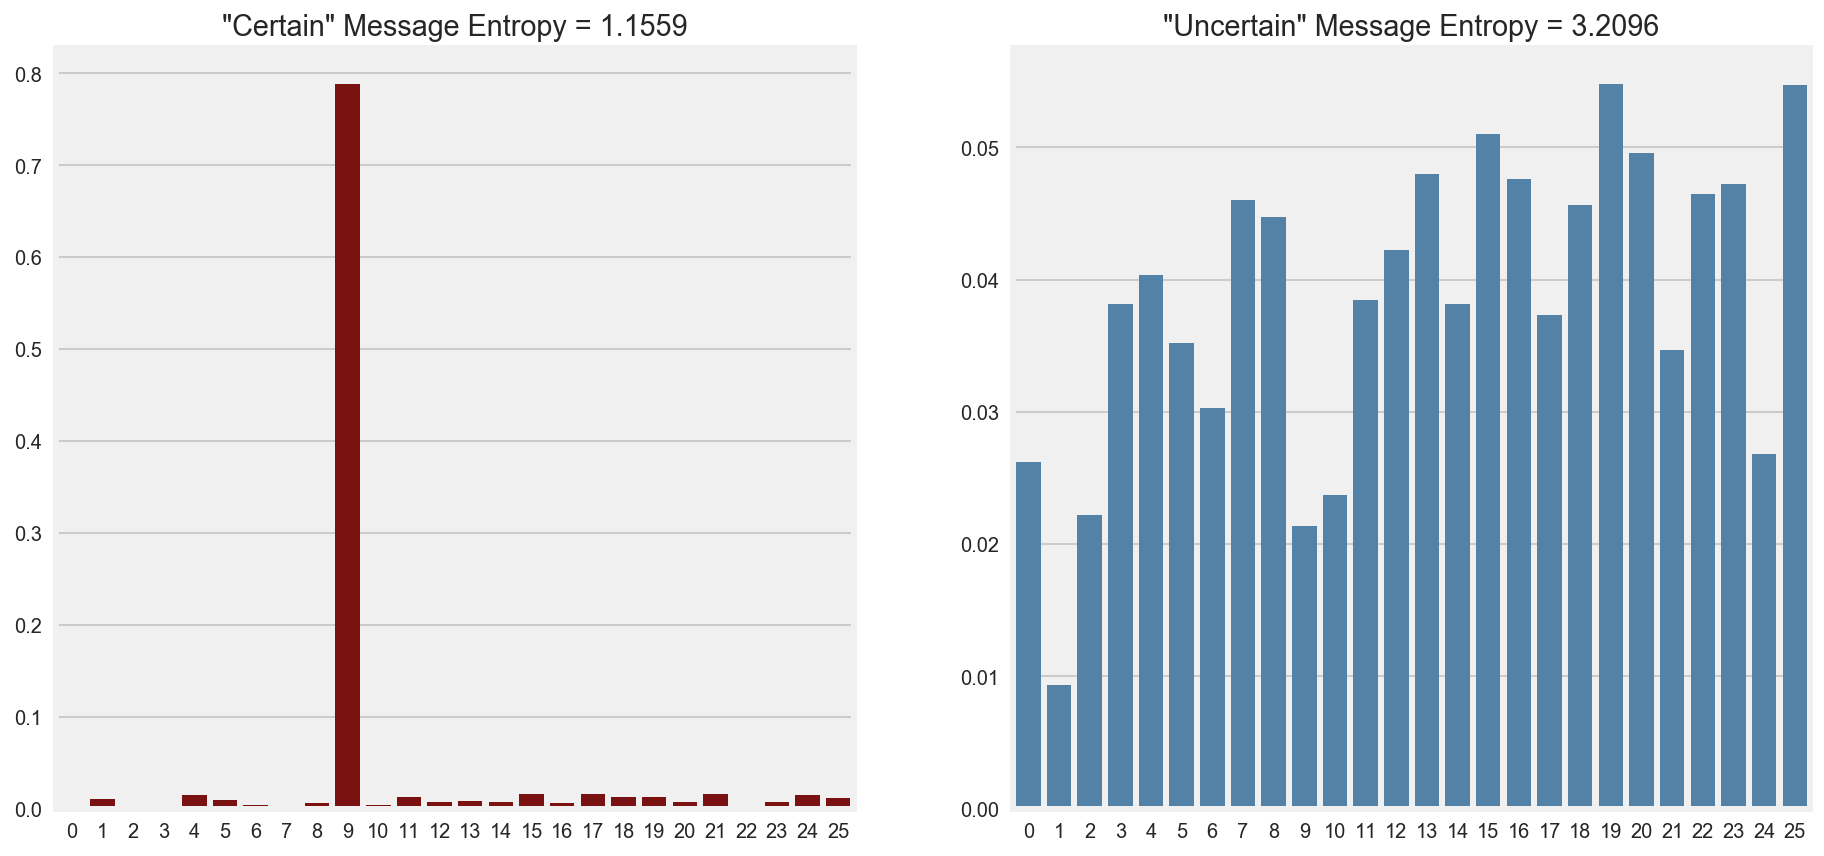

In [22]:
emp_labels = np.array(sorted(target_ref_dict.keys()))

# set up a mesage with high certainty about one empathy:
certain = np.array([1. if e == 9 else 0. for e in emp_labels]) + np.random.random(len(emp_labels))*0.02
certain = certain/certain.sum()

# set up an uncertain message - many empathies are possible:
uncertain = stats.norm(loc=20, scale=10).pdf(emp_labels) + np.random.random(len(emp_labels))*0.05
uncertain = uncertain/uncertain.sum()

fig, ax = plt.subplots(1, 2, figsize=(14,7))
sns.barplot(emp_labels, certain, color='darkred', ci=None, ax=ax[0])
sns.barplot(emp_labels, uncertain, color='steelblue', ci=None, ax=ax[1])

ax[0].set_title('"Certain" Message Entropy = %.4f' % (entropy(certain)))
ax[1].set_title('"Uncertain" Message Entropy = %.4f' % (entropy(uncertain)))

plt.show()

The standard loss for this classifier neural network is the cross entropy loss. Imagine we have our message's predicted probability distribution over empathies, denoted $p$. We also have the actual occuring empathy for that message (the target) as $y$, which will be a 1 at the correct empathy and zero everywhere else. The cross entropy is:

### $$ H(y, p) = - \sum_{i=1}^n y_i \; ln(p_i) $$

Minimizing the cross-entropy is equivalent to minimizing the negative log-likelihood.

We can take a look at what our cross entropy losses would be for these messages, given two target vectors.

In [23]:
certain_target = np.array([1. if e == 9 else 0. for e in emp_labels])
uncertain_target = np.array([1. if e == 20 else 0. for e in emp_labels])

def cross_entropy(true, pred_prob):
    return -1 * np.sum(true * np.log(pred_prob + 1e-12))

certain_ce = cross_entropy(certain_target, certain)
uncertain_ce = cross_entropy(uncertain_target, uncertain)

print('CE Loss for certain:', certain_ce)
print('CE Loss for uncertain:', uncertain_ce)
print('Difference in loss, uncertain-certain:', uncertain_ce-certain_ce)

CE Loss for certain: 0.237592169105
CE Loss for uncertain: 3.00385007144
Difference in loss, uncertain-certain: 2.76625790234


So, obviously our "certain" vector of predicted probabilities has a lower loss since the target class aligns with its prediction.

But maybe we want to avoid getting _really_ certain about target classes. Having super high certainty about classes is indicative of overfitting. We can actually add a penalty to the loss function that rewards predicted probability distributions with higher entropy:

### $$ L(y, p) = - \sum_{i=1}^n y_i \; ln(p_i) - \beta \sum_{i=1}^n p_i\;ln(p_i) $$

Where $\beta$ is some regularization strength.

We can set $\beta = 1.0$ and see what happens to our losses when we apply the penalty favoring higher entropy distributions:

In [24]:
beta = 1.0
def penalized_loss(true, pred_prob, beta):
    return cross_entropy(true, pred_prob) - (beta * entropy(pred_prob))

certain_loss = penalized_loss(certain_target, certain, beta)
uncertain_loss = penalized_loss(uncertain_target, uncertain, beta)

print('Penalized loss for certain:', certain_loss)
print('Penalized loss for uncertain:', uncertain_loss)
print('Difference in loss, uncertain-certain:', uncertain_loss-certain_loss)

Penalized loss for certain: -0.918324290661
Penalized loss for uncertain: -0.205721413891
Difference in loss, uncertain-certain: 0.71260287677


The loss can now go below zero, but that's fine, we are just trying to achieve any minimum. You can see that the difference between losses has shrunk considerably since the certain vector is being "punished" more than the uncertain one for having a lower entropy of predicted probabilities.

The choice of $\beta$ sets the importance of having a high-entropy distribution over predicted classes. You could of course turn it up so high that the certain vector was actually performing _worse_ than the uncertain one:

In [25]:
extreme_beta = 10.
certain_loss = penalized_loss(certain_target, certain, extreme_beta)
uncertain_loss = penalized_loss(uncertain_target, uncertain, extreme_beta)

print('Penalized loss for certain:', certain_loss)
print('Penalized loss for uncertain:', uncertain_loss)
print('Difference in loss, uncertain-certain:', uncertain_loss-certain_loss)

Penalized loss for certain: -11.3215724286
Penalized loss for uncertain: -29.0918647819
Difference in loss, uncertain-certain: -17.7702923534


### Self-adjusting $\beta$

Rather than choose an explicit, set value for the regularization strength, I allowed it to adjust itself as a function of the training accuracy like so:

### $$ \beta = \begin{cases}
\text{tanh}(acc) & \text{if} ~~ acc \lt 0.99 \\
\text{tanh}(0.99) & \text{if} ~~ acc \ge 0.99
\end{cases} $$

When the training accuracy is low, the regularization strength will be low. As the training accuracy increases, so does the regularization strength. This is equivalent to telling the network, "as you improve at identifying the empathies correctly, increase the value of entropy in predicted probabilies."

This way, the network focuses more on generalization ability as it improves on the training set, but when it is terrible on the training data it focuses effort on the standard cross entropy loss.

## Training the model
---

The `Trainer` object will control the fitting and iterations of the model. There are a variety of options you can set to control the behavior of the fitting procedure.

There are only three required arguments:

    model
    train_char_indices
    train_targets
    
The optional arguments are:

    class_weights (default None)
        determines how to weight the loss function per class (to deal with class imbalance)
    verbose (default True)
        print out progress statements or not
    save_path (default None)
        where to save the final model parameters
    save_on_path_best (default None)
        where to save the best model on testing
    evaluator (default None)
        an Evaluator object - if not supplied then no test-set validation is done
    sample_size (default 1000)
        the sample size of training sample per iteration
    with_replacement (default True)
        boolean indicating whether to sample the training data with replacement or not
    sample_p (default None)
        sample weights for training data, uniform sampling if left blank
    early_stopping_test_acc (default None)
        threshold for test accuracy in which to stop model fitting
    learning_rate (default 0.01)
        how fast should descent on the gradient move
    entropy_weight (default 0.0)
        how much to weight the class probability entropy penalty of the loss function
    weight_entropy_by_accuracy (default False)
        this will increase or decrease the importance of the entropy penalty as a function of
        training accuracy (if false, entropy_weight is the regularization strength)
        

**Run until a testing accuracy of 0.6 is achieved or 5 iterations pass, then stop.**

You'll obviously want to run it for more than 5 iterations to get good results... but for now just to demonstrate:

In [ ]:
T = Trainer(gru, train_char_indices, train_targets, class_weights=class_weights,
            verbose=True, save_path=save_file, save_on_best_path=save_best,
            evaluator=E, sample_size=1000, sample_p=train_obs_weights,
            entropy_weight=1.0, weight_entropy_by_accuracy=True,
            early_stopping_test_acc=0.6)

In [ ]:
T.training_loop(n_iters=50)

Iteration: 1
New entropy weight: 0.0220
MODEL: 0m 46s (- 38m 14s) (1 2%)   loss: 0.3615   acc: 0.0220
-----------------------------------------------------
TESTING:   loss: 3.4327   acc: 0.0071
-----------------------------------------------------
actually kinda good
   label         p empathy
0     12  0.035938   great
Predicted:
   label         p     empathy
0     14  0.081871        loss
1     20  0.071697       sleep
2      2  0.064635     average
3      5  0.063750  confidence
4     17  0.061940     pensive
-----------------------------------------------------
Iteration: 2
New entropy weight: 0.0150
MODEL: 1m 37s (- 39m 9s) (2 4%)   loss: 0.5345   acc: 0.0150
-----------------------------------------------------
TESTING:   loss: 3.5269   acc: 0.0053
-----------------------------------------------------
great my shop is also going great
   label         p empathy
0     12  0.028822   great
Predicted:
   label         p      empathy
0      0  0.181728        angry
1      9  0.10199

## Evaluating on new phrases
---

You can use the instantiated `Evaluation` object to get predicted probabilities of empathies for your own phrases. You can test for example if the model is resilient to spelling errors.

(You'll need to actually train it long enough to get reasonable output!)

In [28]:
E.eval_message(gru, 'i feel great')

i feel great
   label         p  empathy
0     19  0.054955     sick
1     20  0.054923    sleep
2     17  0.053169  pensive
3     11  0.047842  excited
4     22  0.047028    tired
-----------------------------------------------------


In [29]:
E.eval_message(gru, 'ix ffeel grreaat')

ix ffeel grreaat
   label         p     empathy
0     19  0.062890        sick
1     17  0.057976     pensive
2     22  0.049576       tired
3      6  0.048302   depressed
4      7  0.045649  determined
-----------------------------------------------------
